# The Goddard Problem (Three Phases)

For a solution to the Goddard problem with three phases using a Python script instead of a notebook, see the [Python script documentation](../scripts/goddard_problem_3_phase.rst).

## Problem Description

See the [Python notebook](../notebooks/goddard_problem_1_phase.ipynb) for the Goddard problem with one phase for a general description of the Goddard problem. In that notebook, we found that there is likely a singular arc in the middle portion of the solution.

For a complete discussion of the singular arc in the Goddard rocket problem, see See Bryson and Ho <cite data-footcite="Bryson:1975">(1975)</cite>, Section 8.3. It turns out that for the problem as formulated here (with an exponential atmosphere), there is an additional constraint during the singular arc phase that
$$
m(t)g - \left( 1 + \frac{v(t)}{c} \right) D(t) = 0
$$
where $m(t)$ is the mass of the rocket, $v(t)$ is the velocity, $c$ is the exit velocity of the propellant, and $D(t)$ is the drag. This constraint is enforced by adding a path constraint the the continuous callback function during phase $p=1$ (*i.e.*, the second phase).

## YAPSS Solution

We begin by importing the required Python packages, and instantiating the problem with the proper dimensions:

In [1]:
# third party imports
import matplotlib.pyplot as plt

# package imports
from yapss.math import exp
from yapss import Problem

# instantiate the problem
problem = Problem(
    name="Goddard Rocket Problem with Singular Arc",
    nx=[3, 3, 3],
    nu=[1, 1, 1],
    nh=[0, 1, 0],
    nq=[0, 0, 0],
    nd=8,
)

We next define the callback functions, as well as any constants required. We also define any math function required, in this case `exp`, the exponential function.

In [2]:
# physical constants
Tm = 200
g = 32.174
sigma = 5.4915e-05
c = 1580.9425
hs = 23800

# callback functions


def objective(arg) -> None:
    """Goddard Rocket Problem objective function."""
    arg.objective = arg.phase[2].final_state[0]


def continuous(arg) -> None:
    """Goddard Rocket Problem dynamics and path functions."""
    for p in arg.phase_list:
        (h, v, mass) = arg.phase[p].state
        (T,) = arg.phase[p].control
        D = sigma * v**2.0 * exp(-h / hs)
        h_dot = v
        v_dot = (T - D) / mass - g
        m_dot = -T / c
        arg.phase[p].dynamics[:] = (h_dot, v_dot, m_dot)

        if p == 1:
            # there is a path constraint only for the middle phase (p = 1)
            arg.phase[p].path[:] = (mass * g - (1 + v / c) * D,)


def discrete(arg) -> None:
    """Goddard Rocket Problem discrete constraint function."""
    phase = arg.phase
    arg.discrete = [
        phase[0].final_time - phase[1].initial_time,
        *(phase[0].final_state - phase[1].initial_state),
        phase[1].final_time - phase[2].initial_time,
        *(phase[1].final_state - phase[2].initial_state),
    ]


problem.functions.objective = objective
problem.functions.continuous = continuous
problem.functions.discrete = discrete

We next set bounds on decision variables and constraints. The discrete constraints ensure that the states are continuous across phase boundaries. Note also the path constraint in the second phase (``p=1``) to enforce the singular arc condition.

In [3]:
# Initial conditions
h0 = 0
v0 = 0
m0 = 3
mf = 1

# begin bounds: phase 0
bounds = problem.bounds.phase[0]
bounds.initial_time.lower = bounds.initial_time.upper = 0
bounds.initial_state.lower[:] = bounds.initial_state.upper[:] = h0, v0, m0
bounds.control.lower[:] = bounds.control.upper[:] = Tm

for p in range(3):
    problem.bounds.phase[p].state.lower[:] = h0, v0, mf
    problem.bounds.phase[p].state.upper[:] = 20000, 10000, m0

# ... phase 1
bounds = problem.bounds.phase[1]
bounds.control.lower[:] = 0
bounds.control.upper[:] = Tm
bounds.path.lower[:] = 0
bounds.path.upper[:] = 0

# ... phase 2
bounds = problem.bounds.phase[2]
bounds.final_state.lower[2] = bounds.final_state.upper[2] = mf
bounds.final_state.lower[1] = 0
bounds.final_state.upper[1] = float("inf")
bounds.control.lower[:] = bounds.control.upper[:] = 0

problem.bounds.discrete.lower[:] = 0
problem.bounds.discrete.upper[:] = 0

The initial guess is very crude. The guess is that the state increases linearly over time; that the velocity is constant; that the mass decreases linearly in time; and that each phase is 15 seconds.

In [4]:
# begin guess
for p in range(3):
    problem.guess.phase[p].time = [15 * p, 15 * (p + 1)]
    problem.guess.phase[p].state = [
        (6000 * p, 6000 * (p + 1)),
        (500, 500),
        (3 - 2 / 3 * p, 3 - 2 / 3 * (p + 1)),
    ]
    problem.guess.phase[p].control = [(Tm * (2 - p) / 2, Tm * (2 - p) / 2)]

Scaling might improve the rate of convergence, but it's not really needed for this problem. But we do scale the objective by -1, so that the objective (final height) is maximized instead of minimized:

In [5]:
problem.scale.objective = -1

Set the solver parameters:

In [6]:
problem.ipopt_options.max_iter = 500
problem.derivatives.order = "second"
problem.derivatives.method = "auto"
problem.spectral_method = "lgl"

problem.ipopt_options.tol = 1e-20
problem.ipopt_options.print_level = 3

Find the optimal solution:

In [7]:
solution = problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:     1001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      906
                     variables with only upper bounds:        0
Total number of equality constraints.................:      999
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 31

     

## Plot the Solution

First, we extract the data from the solution:

In [8]:
# extract information from solution
time = []
time_c = []
state = []
control = []
costate = []
dynamics = []
integrand = []

for p in range(3):
    time.append(solution.phase[p].time)
    time_c.append(solution.phase[p].time_c)
    state.append(solution.phase[p].state)
    control.append(solution.phase[p].control)
    costate.append(solution.phase[p].costate)
    dynamics.append(solution.phase[p].dynamics)
    integrand.append(solution.phase[p].integrand)

t0 = solution.phase[0].initial_time
tf = solution.phase[2].final_time

# plot defaults
plt.rcParams["lines.linewidth"] = 2

### Thrust

We begin by plotting the thrust history:

Singular arc occurs between t = 13.14 and t = 21.75.


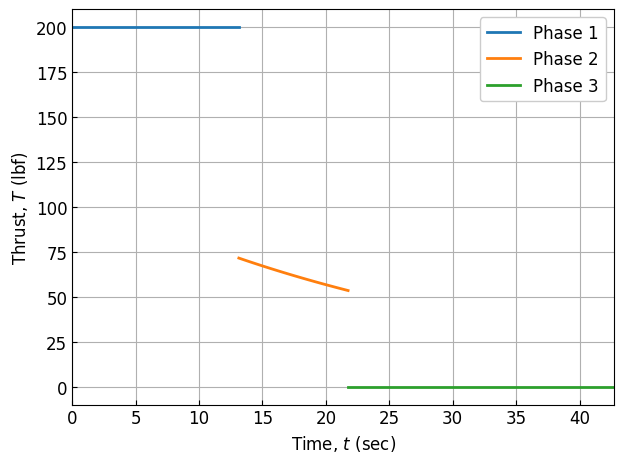

In [9]:
# thrust
plt.figure(1)
ax = plt.axes()
line = []
for p in range(3):
    line1 = ax.plot(time_c[p], control[p][0])
    line.append(line1)
print(f"Singular arc occurs between t = {time[1][0]:.2f} and t = {time[1][-1]:.2f}.")
plt.ylabel("Thrust, $T$ (lbf)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.legend(("Phase 1", "Phase 2", "Phase 3"), framealpha=1.0)
plt.grid()
plt.tight_layout()

In [10]:
print(f"Singular arc occurs between t = {time[1][0]:.2f} and t = {time[1][-1]:.2f}.")

Singular arc occurs between t = 13.14 and t = 21.75.


Note that the solution consists of three phases. In the first phase, the thrust is at the thrust upper bound. In the second phase, the thrust is intermediate, due to the singular arc. In the third phase, the thrust is at the thrust lower bound. A control solution of this form is often referred to as *bang-singular-bang* control.

### Altitude

Plot the altitude:

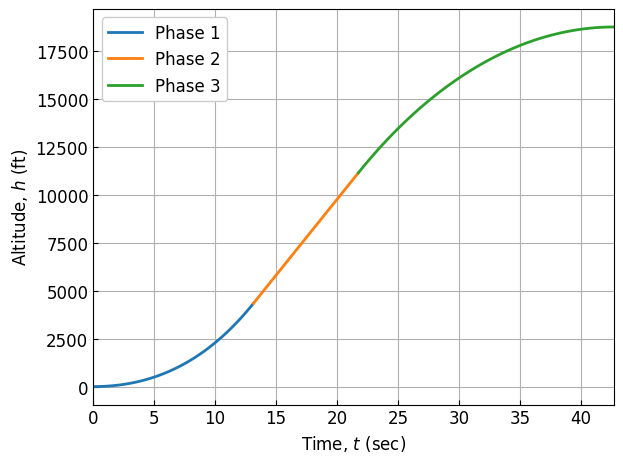

In [11]:
# altitude
plt.figure(2)
ax = plt.axes()
line = []
for p in range(3):
    line1 = ax.plot(time[p], state[p][0])
    line.append(line1)
plt.ylabel("Altitude, $h$ (ft)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.legend(("Phase 1", "Phase 2", "Phase 3"), framealpha=1.0)
plt.grid()
plt.tight_layout()

Note that the velocity history looks essentially the same as the velocity  history for the one-phase solution.

### Velocity

Plot the velocity:

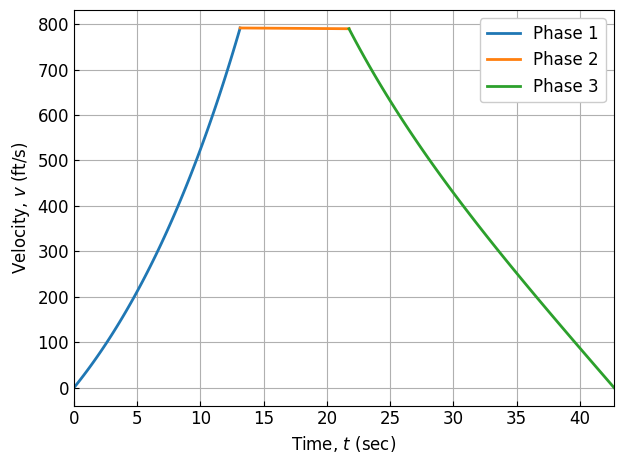

In [12]:
# velocity
plt.figure(3)
ax = plt.axes()
line = []
for p in range(3):
    line1 = ax.plot(time[p], state[p][1])
    line.append(line1)
plt.ylabel("Velocity, $v$ (ft/s)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.legend(("Phase 1", "Phase 2", "Phase 3"), framealpha=1.0)
plt.grid()
plt.tight_layout()

The velocity history looks similar to that in the one-phase solution, except that it does not have the raggedness of the one-phase solution.

### Mass

Plot the mass history:

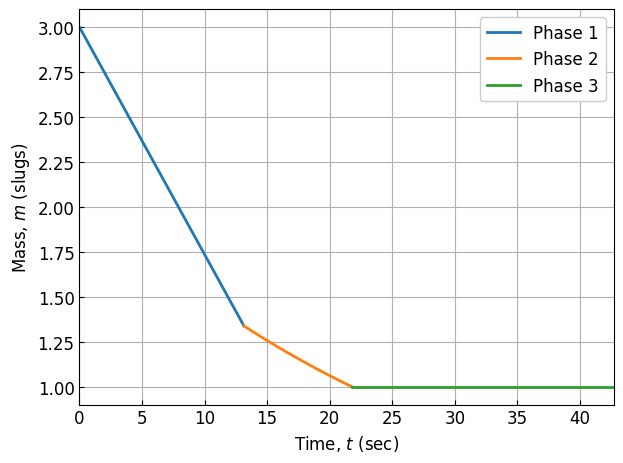

In [13]:
# mass
plt.figure(4)
ax = plt.axes()
line = []
for p in range(3):
    line1 = ax.plot(time[p], state[p][2])
    line.append(line1)
plt.ylabel("Mass, $m$ (slugs)")
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.legend(("Phase 1", "Phase 2", "Phase 3"), framealpha=1.0)
plt.grid()
plt.tight_layout()

Again, the history plotted above is similar to that in the one-phase solution, except that there is no raggedness during the singular arc.

### Hamiltonian

We next plot the Hamiltonian for the solution:

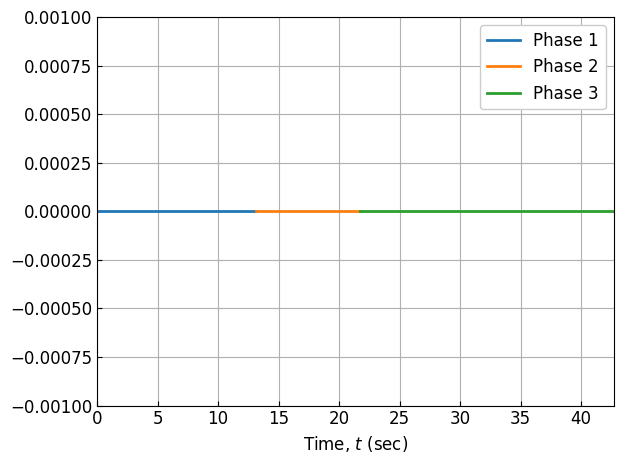

In [14]:
# hamiltonian
plt.figure()
# ax = plt.axes()
line = []
for p in range(3):
    hamiltonian = sum(dynamics[p][i] * costate[p][i] for i in range(3))
    plt.plot(time_c[p], hamiltonian)
plt.xlim([t0, tf])
plt.ylim([-0.001, 0.001])
plt.xlabel("Time, $t$ (sec)")
plt.xlim([t0, tf])
plt.legend(("Phase 1", "Phase 2", "Phase 3"), framealpha=1.0)
plt.grid()
plt.tight_layout()

We see that, unlike in the one-phase solution, the numerical value of the Hamiltonian is in fact constant, as it should be.